# Train Pixel Classifier

In [73]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize as sklearn_normalize
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

np.random.seed(1)

In [ ]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

In [114]:
def normalize(x):
    return (np.array(x)) / (3000)

def compute_ndvi(pixel_vectors):
    return (pixel_vectors[:,7] - pixel_vectors[:,3]) / (pixel_vectors[:,7] + pixel_vectors[:,3])

## Create a Training Dataset
Outputs will be: `x_train`, `y_train`, `x_test`, `y_test`, `x_holdout`, `y_holdout`. Holdout data is only positive

In [58]:
train_data_dir = '../data/sentinel'

with open(os.path.join(train_data_dir, "negative_pixel_vectors_toa_12_2019-01-01.pkl"), 'rb') as file:
    x_negative = np.array(pickle.load(file))


# Bootstrap data is an example for now of adding data to classifier
#with open(os.path.join(train_data_dir, "bootstrap_data_toa.pkl"), 'rb') as file:
#    x_negative_bootstrap = np.array(pickle.load(file))
    
#x_negative = np.concatenate((x_negative, x_negative_bootstrap))

y_negative = np.zeros(len(x_negative))

with open(os.path.join(train_data_dir, "positive_pixel_vectors_toa_36_2018-01-01.pkl"), 'rb') as file:
    x_positive = np.array(pickle.load(file))

with open(os.path.join(train_data_dir, "positive_holdout_pixel_vectors_toa_3_2018-01-01.pkl"), 'rb') as file:
    x_holdout = np.array(pickle.load(file))

### Filter positive samples such that NDVI is within a range
This is useful since the positive patches can include surrounding vegetation

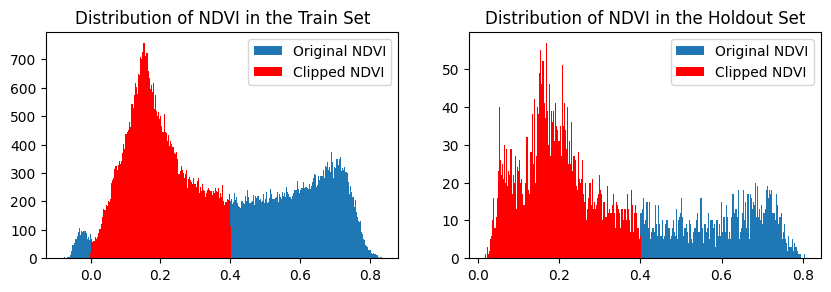

In [59]:
ndvi_train = compute_ndvi(x_positive)
ndvi_holdout = compute_ndvi(x_holdout)

lower_ndvi_bound = 0
upper_ndvi_bound = 0.4
index_train = np.logical_and(ndvi_train > lower_ndvi_bound, ndvi_train < upper_ndvi_bound)
index_holdout = np.logical_and(ndvi_holdout > lower_ndvi_bound, ndvi_holdout < upper_ndvi_bound)

x_positive = x_positive[index_train]
y_positive = np.ones(len(x_positive))
x_holdout = x_holdout[index_holdout]
y_holdout = np.ones(len(x_holdout))

plt.figure(figsize=(10,3), dpi=100, facecolor=(1,1,1))
plt.subplot(1,2,1)
edges, bins, patches = plt.hist(ndvi_train, bins=300, label='Original NDVI')
plt.hist(ndvi_train[index_train], bins=bins, color='r', label='Clipped NDVI')
plt.title('Distribution of NDVI in the Train Set')
plt.legend()

plt.subplot(1,2,2)
edges, bins, patches = plt.hist(ndvi_test, bins=300, label='Original NDVI')
plt.hist(ndvi_holdout[index_holdout], bins=bins, color='r', label='Clipped NDVI')
plt.title('Distribution of NDVI in the Holdout Set')
plt.legend()

plt.show()

### Create train test split
Also expand dimensions to account for batches

In [60]:
x = np.concatenate((x_positive, x_negative))
y = np.concatenate((y_positive, y_negative))

x, y = shuffle(x, y, random_state=42)
x = normalize(x)
x_holdout = normalize(x_holdout)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
print("Num Train Samples:\t\t", len(x_train))
print("Num Test Samples:\t\t", len(x_test))
print(f"Percent Negative Train:\t {100 * sum(y_train == 0.0) / len(y_train):.1f}")
print(f"Percent Negative Test:\t {100 * sum(y_test == 0.0) / len(y_test):.1f}")

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_holdout = np.expand_dims(x_holdout, -1)
x_positive_test = np.expand_dims(x_positive_test, -1)

# Note: I am accustomed to assigning two classes for binary classification. 
# This habit comes from an issue in theano a long time ago, but I'm too superstitious to change it.
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_holdout = keras.utils.to_categorical(y_holdout, num_classes)

Num Train Samples:		 500854
Num Test Samples:		 125214
Percent Negative Train:	 92.8
Percent Negative Test:	 92.7


## Create and Train a Model

In [33]:
input_shape = np.shape(x_train[0])
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv1D(16, kernel_size=(3), activation="relu"),
        #layers.MaxPooling2D(pool_size=(2)),
        layers.Conv1D(32, kernel_size=(3), activation="relu"),
        #layers.MaxPooling2D(pool_size=(2)),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 16)            64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 32)             1568      
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

### Optional Class Weighting
Over experimental testing, I found that weighting classes seemed to degrade performance. This could use further investigation

In [34]:
from sklearn.utils import class_weight
negative_weight, positive_weight = class_weight.compute_class_weight('balanced', 
                                                                     classes = np.unique(y_train),
                                                                     y = y_train[:,1])
print(f"Negative Weight: {negative_weight:.2f}")
print(f"Positive Weight: {positive_weight:.2f}")

Negative Weight: 0.54
Positive Weight: 6.91


In [35]:
# Compile model. Note that many of these metrics are extraneous. 
# Can be useful to track during training at times though
model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=[keras.metrics.Recall(thresholds=(0.9), name='precision'), 
                       keras.metrics.Precision(thresholds=(0.9), name='recall'),
                       keras.metrics.AUC(curve='PR', name='auc'),
                       "accuracy"],
              #loss_weights = sum(y_train) / len(y_train),
              #weighted_metrics = ['accuracy']
             )

### Train the Model

In [36]:
batch_size = 256
epochs = 10

model.fit(x_train, 
          y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data = (x_test, y_test),
          #validation_split=0.1,
          #class_weight = {0: negative_weight, 1: positive_weight}
         )

Epoch 1/10
1957/1957 [==============================] - 6s 3ms/step - loss: 0.2010 - precision: 0.7193 - recall: 0.9741 - auc: 0.9740 - accuracy: 0.9294 - val_loss: 0.1600 - val_precision: 0.7503 - val_recall: 0.9862 - val_auc: 0.9848 - val_accuracy: 0.9406
Epoch 2/10
1957/1957 [==============================] - 6s 3ms/step - loss: 0.1560 - precision: 0.7874 - recall: 0.9830 - auc: 0.9847 - accuracy: 0.9416 - val_loss: 0.1431 - val_precision: 0.7974 - val_recall: 0.9857 - val_auc: 0.9873 - val_accuracy: 0.9454
Epoch 3/10
1957/1957 [==============================] - 6s 3ms/step - loss: 0.1452 - precision: 0.8015 - recall: 0.9850 - auc: 0.9867 - accuracy: 0.9453 - val_loss: 0.1369 - val_precision: 0.8369 - val_recall: 0.9830 - val_auc: 0.9885 - val_accuracy: 0.9479
Epoch 4/10
1957/1957 [==============================] - 6s 3ms/step - loss: 0.1389 - precision: 0.8107 - recall: 0.9861 - auc: 0.9879 - accuracy: 0.9467 - val_loss: 0.1316 - val_precision: 0.8105 - val_recall: 0.9888 - val_auc

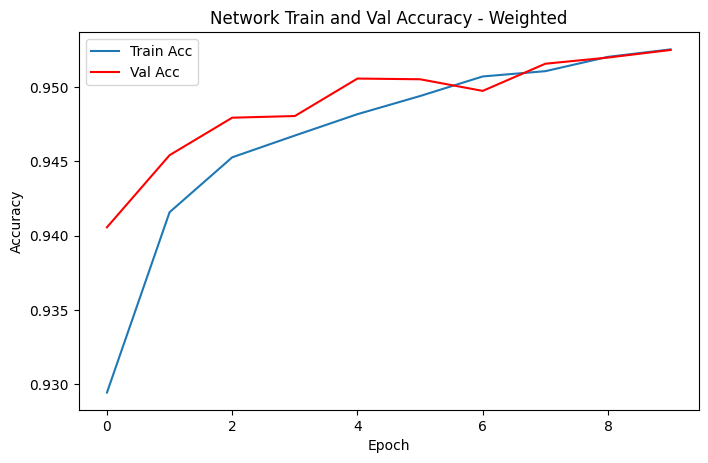

In [37]:
plt.figure(figsize=(8,5), dpi=100, facecolor=(1,1,1))
plt.plot(model.history.history['accuracy'], label='Train Acc')
plt.plot(model.history.history['val_accuracy'], c='r', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Network Train and Val Accuracy')
plt.show()

In [62]:
from sklearn.metrics import classification_report
print("Test Set Metrics:")
print(classification_report(y_test[:,1], model.predict(x_test)[:,1] > 0.6, 
                            target_names=['No TPA', 'TPA']))

print("\nHoldout Positive Set Metrics:")
print(classification_report(y_holdout[:,1], model.predict(x_holdout)[:,1] > 0.6, 
                            target_names=['No TPA', 'TPA']))

Test Set Metrics:
              precision    recall  f1-score   support

      No TPA       0.95      0.99      0.97    116111
         TPA       0.83      0.39      0.54      9103

    accuracy                           0.95    125214
   macro avg       0.89      0.69      0.75    125214
weighted avg       0.95      0.95      0.94    125214


Holdout Positive Set Metrics:
              precision    recall  f1-score   support

      No TPA       0.00      0.00      0.00         0
         TPA       1.00      0.35      0.52      3167

    accuracy                           0.35      3167
   macro avg       0.50      0.17      0.26      3167
weighted avg       1.00      0.35      0.52      3167



In [36]:
model.save('../models/65_mo_tpa_bootstrap_toa-12-20-2020.h5')

In [64]:
model_path = '/Users/ckruse/Downloads/test_model.h5'
model.save(model_path)

## Visualize Network Predictions

In [139]:
def stretch_histogram(array, min_val=0.1, max_val=0.75, gamma=1.2):
    clipped = np.clip(array, min_val, max_val)
    stretched = (clipped - min_val) / (max_val - min_val) ** gamma
    return stretched

def make_predictions(model_path, data, site_name, threshold):
    test_image = data
    model = keras.models.load_model(model_path)

    rgb_stack = []
    preds_stack = []
    threshold_stack = []
    print("Making Predictions")
    for month in tqdm(list(test_image.keys())):
        test_pixel_vectors, width, height = get_pixel_vectors(test_image, month)
        if width > 0:
            test_pixel_vectors = normalize(test_pixel_vectors)

            r = np.reshape(np.array(test_pixel_vectors)[:,3], (width, height))
            g = np.reshape(np.array(test_pixel_vectors)[:,2], (width, height))
            b = np.reshape(np.array(test_pixel_vectors)[:,1], (width, height))
            rgb = np.stack((r,g,b), axis=-1)
            rgb_stack.append(rgb)

            preds = model.predict(np.expand_dims(test_pixel_vectors, axis=-1))
            preds_img = np.reshape(preds, (width, height, 2))[:,:,1]
            preds_stack.append(preds_img)

            thresh_img = np.clip(preds_img, threshold, 1)
            threshold_stack.append(thresh_img)
            
    rgb_median = np.median(rgb_stack, axis=0)
    preds_median = np.median(preds_stack, axis=0)
    threshold_median = np.median(threshold_stack, axis=0)

    plt.figure(dpi=150, facecolor=(1,1,1), figsize=(15,5))

    plt.subplot(1,3,1)
    
    adjusted_image = stretch_histogram(rgb_median)
    plt.imshow(adjusted_image)
    plt.title(f'{site_name} Median', size=8)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(preds_median, vmin=0, vmax=1, cmap='seismic')
    plt.title('Classification Median', size=8)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(threshold_median, cmap='gray')
    plt.title(f"Positive Pixels Median: Threshold {threshold}", size=8)
    plt.axis('off')

    title = f"{site_name} - Median Values - Neural Network Classification - Threshold {threshold}"
    plt.suptitle(title, y=1.01)
    plt.tight_layout()
    #plt.savefig(os.path.join(output_dir, title + '.png'), bbox_inches='tight')
    plt.show()
    
    return rgb_stack, preds_stack, threshold_stack

### Download a test patch

In [140]:
test_coords = [-122.38868885793899, 37.96570154591359]
name = 'berkeley'
rect_width = 0.01
threshold = 0.8

In [106]:
patch_history = get_history([test_coords], 
                            [name], 
                            rect_width,
                            start_date='2019-06-01',
                            num_months=12
                           )

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:02<00:32,  2.98s/it]

 17%|█▋        | 2/12 [00:05<00:27,  2.71s/it]

 25%|██▌       | 3/12 [00:08<00:25,  2.86s/it]

 33%|███▎      | 4/12 [00:12<00:25,  3.23s/it]

 42%|████▏     | 5/12 [00:19<00:31,  4.45s/it]

 50%|█████     | 6/12 [00:28<00:34,  5.68s/it]

 58%|█████▊    | 7/12 [00:34<00:30,  6.01s/it]

 67%|██████▋   | 8/12 [00:37<00:19,  4.82s/it]

 75%|███████▌  | 9/12 [00:42<00:15,  5.08s/it]

 83%|████████▎ | 10/12 [00:50<00:12,  6.04s/it]

 92%|█████████▏| 11/12 [00:59<00:06,  6.70s/it]

100%|██████████| 12/12 [01:07<00:00,  5.63s/it]


### Show composite predictions

  0%|          | 0/12 [00:00<?, ?it/s]

Making Predictions


100%|██████████| 12/12 [00:03<00:00,  3.30it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


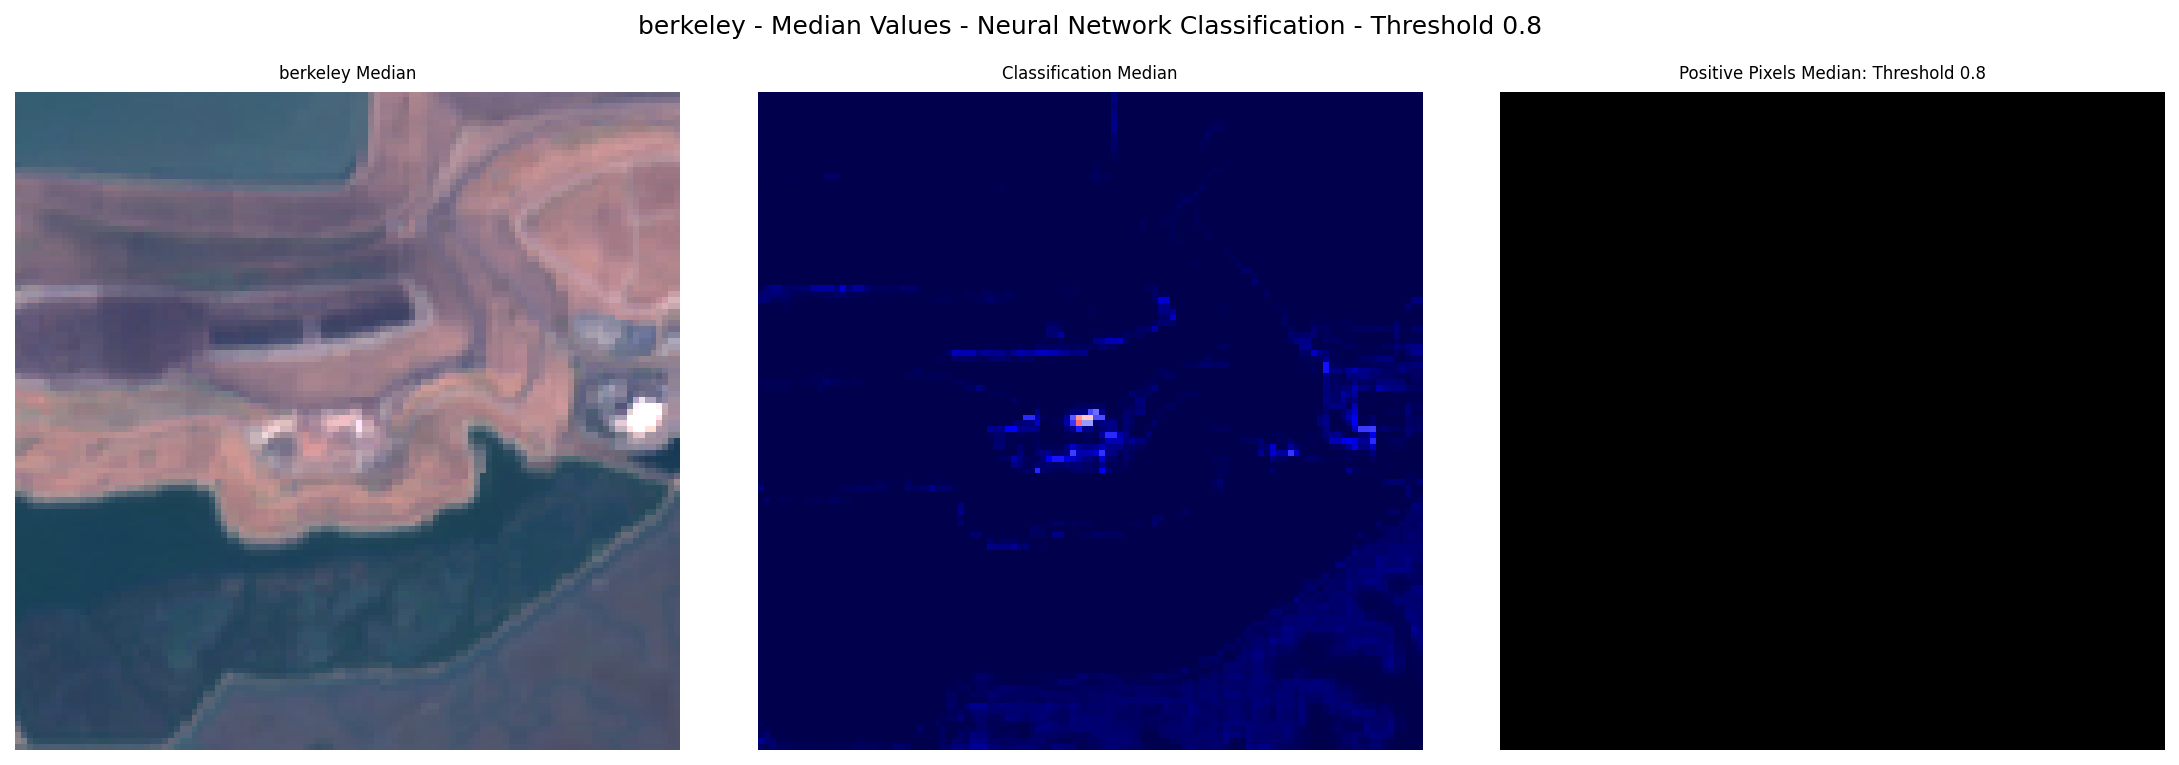

In [141]:
rgb_stack, pred_stack, threshold_stack = make_predictions(model_path, patch_history, name, threshold)

### Show timeseries predictions

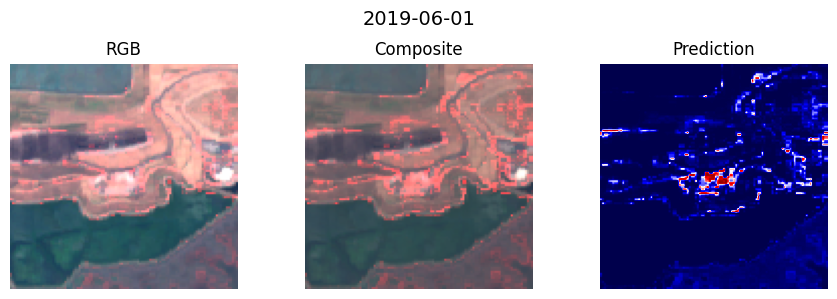

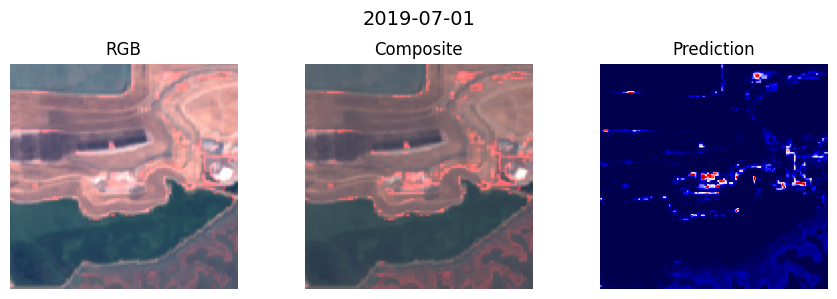

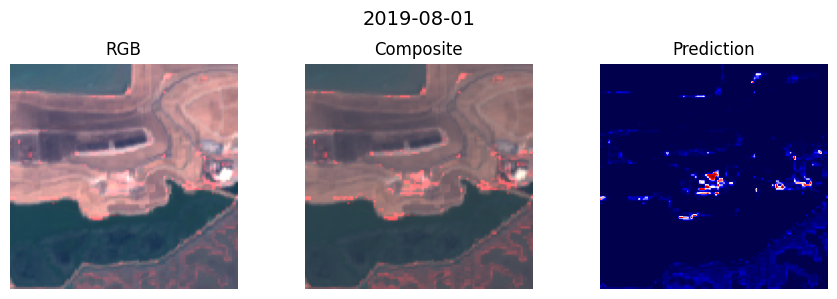

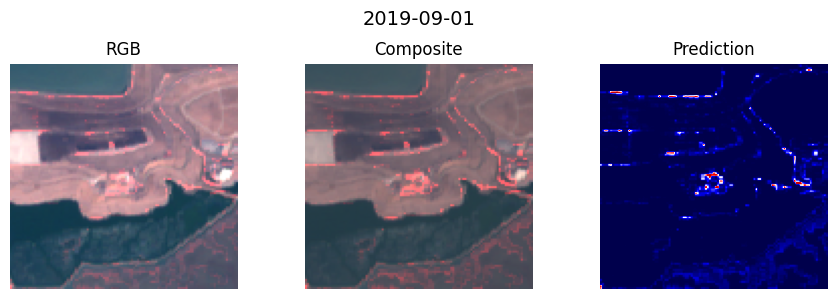

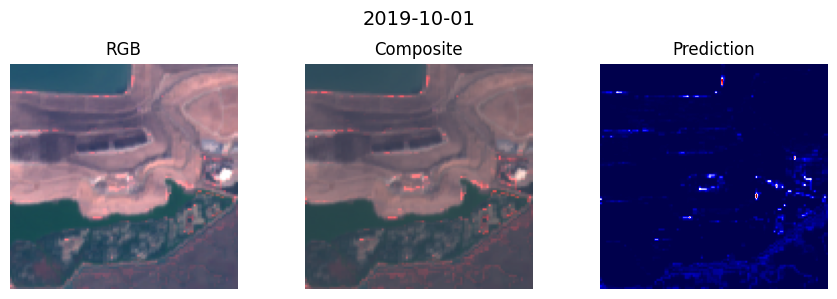

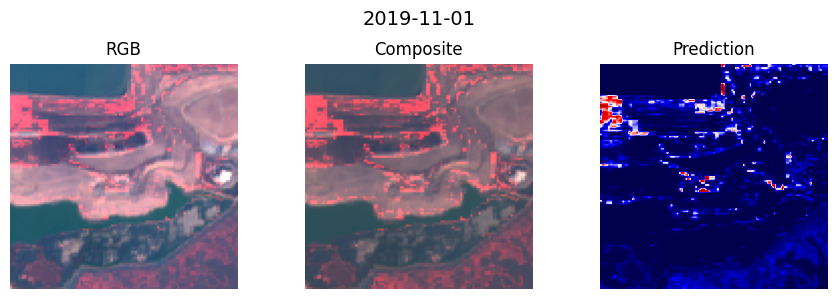

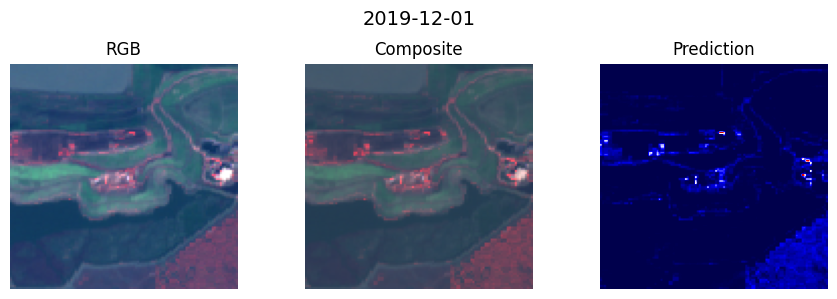

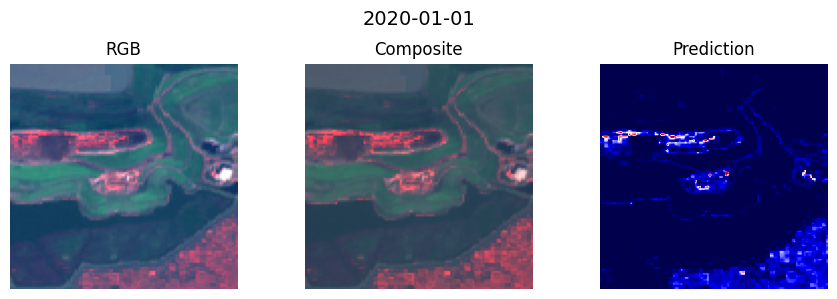

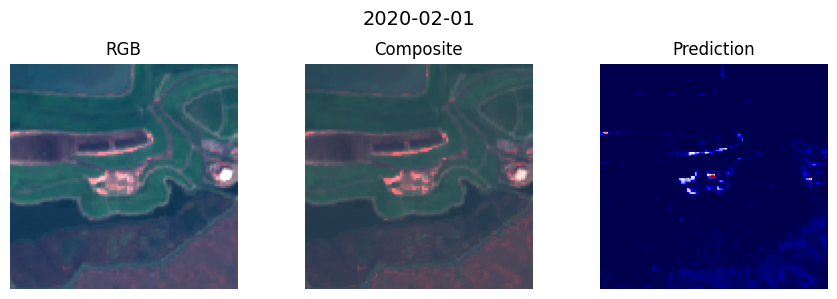

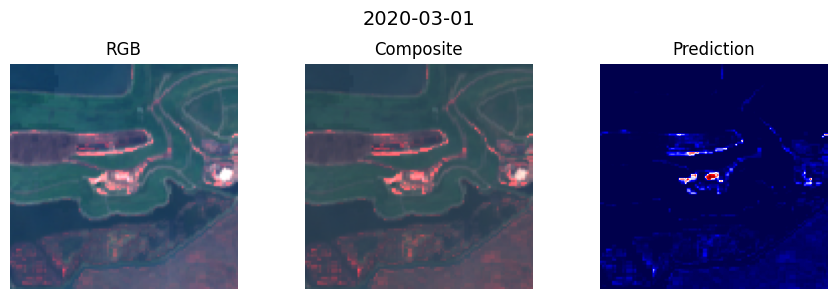

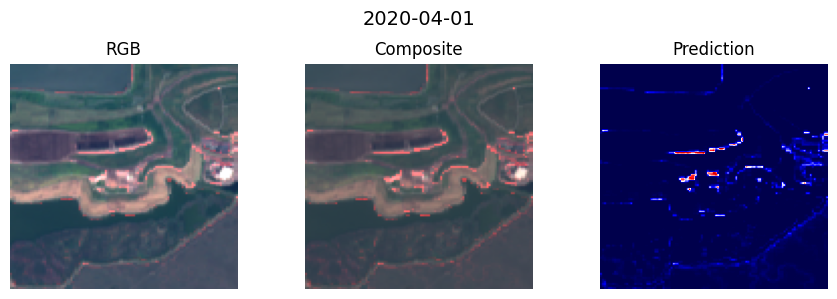

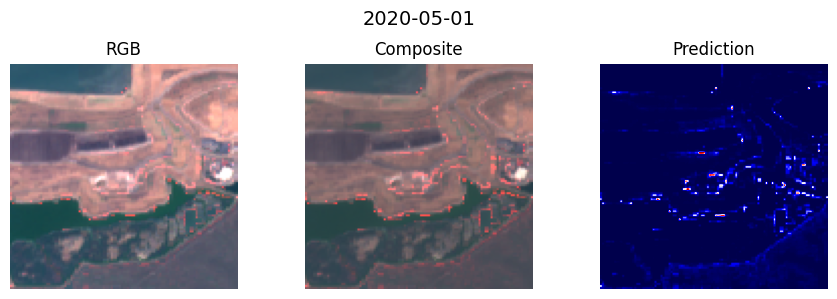

Computation timed out.


In [143]:
for image, pred, date in zip(rgb_stack, pred_stack, list(patch_history.keys())):
    plt.figure(figsize=(9,3), facecolor=(1,1,1), dpi=100)
    plt.subplot(1,3,1)
    plt.imshow(np.clip(stretch_histogram(image), 0, 1))
    plt.axis('off')
    plt.title('RGB')
    
    plt.subplot(1,3,2)
    combo = image
    combo[:,:,0] += pred
    plt.imshow(np.clip(combo, 0, 1))
    plt.axis('off')
    plt.title('Composite')
    
    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='seismic')
    plt.title('Prediction')
    plt.axis('off')
    
    plt.suptitle(date, size=14)
    plt.tight_layout()
    plt.show()